# My First AI Project: Finding Pneumonia in X-Rays

Hi! I am building my first AI project. The goal is to make the computer look at a chest X-ray and tell if the person has Pneumonia or not.

I am going to take this very slow and explain everything I do, step-by-step.

### Step 1: Getting the tools
First, I need to download the libraries. These are like toolboxes that have the code I need.

In [1]:
!pip install torch torchvision opencv-python matplotlib scikit-learn seaborn pandas

### Step 2: Importing the main library
People say PyTorch is good for AI, so I am importing it here.

In [2]:
!pip install torch torchvision torchaudio

In [3]:
import sys
print(sys.executable)

/Volumes/X9 Pro/Resume Project/Xray/env/bin/python


In [4]:
!pip install torch torchvision torchaudio --quiet

In [5]:
import torch

### Step 3: Checking for a Graphics Card
I heard AI runs faster on a GPU (Graphics Card). I am checking if I have one available. If not, I'll just use the CPU (which is slower but fine).

In [6]:
# Asking PyTorch if CUDA (the graphics card thing) is ready
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"My computer is using: {device}")

My computer is using: cpu


### Step 4: Getting the image helper
I need `torchvision` to help me deal with pictures.

In [7]:
from torchvision import transforms

### Step 5: Setting the rules for Training
I read that I should mess up the training images a little bit (rotate them, zoom in) so the AI gets smarter and doesn't just memorize the photos.

In [8]:
# I am creating a list of changes to apply to training photos
train_transform = transforms.Compose([
    transforms.RandomRotation(15),      # Spin the photo a little bit
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Zoom in randomly
    transforms.RandomHorizontalFlip(),  # Flip it like a mirror
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),              # Turn the photo into numbers
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # I copied these numbers from the internet, they are standard
])

### Step 6: Setting the rules for Testing
When I test the AI later, I shouldn't spin the images. I just want to resize them so they fit into the AI.

In [9]:
# Just resize these ones, don't flip them
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Step 7: Where are my photos?
My photos are in the `chest_xray` folder.

In [10]:
import os
from torchvision import datasets

data_dir = 'chest_xray'

### Step 8: Loading the Training photos
I am using `ImageFolder`. It's cool because it finds the photos automatically.

In [11]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
print(f"I found {len(train_data)} training photos!")

I found 5216 training photos!


### Step 9: Loading the Test photos
Doing the same thing for the test folder.

In [12]:
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)
print(f"I found {len(test_data)} test photos!")

I found 637 test photos!


### Step 10: What are the categories?
Let's see what categories (classes) the code found inside the folders.

In [13]:
class_names = train_data.classes
print(f"The categories are: {class_names}")

The categories are: ['NORMAL', 'PNEUMONIA']


### Step 11: Making a 'Loader' for Training
I can't give the AI all 5000 images at once. This 'Loader' will give me 16 images at a time.

In [14]:
from torch.utils.data import DataLoader

# Shuffle=True means pick them randomly
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

### Step 12: Making a 'Loader' for Testing
Same thing for the test set.

In [15]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

### Step 13: Getting the Brain library
I need `models` to pick a brain.

In [16]:
from torchvision import models

### Step 14: Downloading ResNet18
I chose **ResNet18** because everyone says it's good and fast. `pretrained=True` means it has already studied millions of other pictures, so it's smart.

In [17]:
model = models.resnet18(pretrained=True)
print("I have downloaded the model!")

/Volumes/X9 Pro/Resume Project/Xray/env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/X9 Pro/Resume Project/Xray/env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


I have downloaded the model!


### Step 15: Don't forget what you learned!
Since ResNet is already smart, I am going to "freeze" it so it doesn't forget everything it knows.

In [18]:
# Loop through all the parts of the model and lock them
for param in model.parameters():
    param.requires_grad = False

### Step 16: Checking the connection
I need to connect a new layer at the end. First, I check how many wires are coming into the final layer.

In [19]:
num_ftrs = model.fc.in_features
print(f"The model expects {num_ftrs} inputs at the end.")

The model expects 512 inputs at the end.


### Step 17: Creating my own layer
ResNet usually detects 1000 things (like cats, dogs, planes). I only want it to detect 2 things (Normal or Pneumonia). So I make a new layer with 2 outputs.

In [20]:
import torch.nn as nn

new_layer = nn.Linear(num_ftrs, 2)

### Step 18: Attaching my layer
I am swapping the old last layer with my new one.

In [21]:
model.fc = new_layer

### Step 19: Moving the Brain to the GPU
Sending the model to the graphics card.

In [22]:
model = model.to(device) 
print("Model is on the GPU now.")

Model is on the GPU now.


### Step 20: Calling the Teacher (Optimizer)
The optimizer is like a teacher who corrects the AI's mistakes. I am using `Adam`.

In [23]:
import torch.optim as optim

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Step 21: The "Score" helper (Loss Function)
This tool calculates how wrong the AI's guess was. If the AI guesses wrong, the score (Loss) goes up.

In [24]:
criterion = nn.CrossEntropyLoss()

### Step 22: Teaching functions
This is the loop where the learning happens.
1. The AI guesses.
2. We check if it is wrong.
3. We tell the optimizer to fix it.

In [25]:
def train_one_epoch(model, train_loader):
    model.train() # Tell the model "Class is in session!"
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 1. Reset the teacher's pen
        optimizer.zero_grad()

        # 2. Make a guess
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # 3. See how wrong it was
        loss = criterion(outputs, labels)

        # 4. Learn from the mistake
        loss.backward()
        optimizer.step()

        # Record the score so we can see it later
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

### Step 23: Start Learning!
I am going to let it train for 3 epochs (rounds).

In [26]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Round {epoch+1} starting...")
    train_one_epoch(model, train_loader)

Round 1 starting...
Train Loss: 0.2849 Acc: 0.8794
Round 2 starting...
Train Loss: 0.1961 Acc: 0.9233
Round 3 starting...
Train Loss: 0.1767 Acc: 0.9296


### Step 24: Testing Time
Now that it learned, let's test it on photos it has never seen before.

In [27]:
model.eval() # Tell the model "Class is over, time for the exam!"
y_true = []
y_pred = []

print("Taking the exam...")
with torch.no_grad(): # Don't learn during the exam
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
print("Exam finished.")

Taking the exam...
Exam finished.


### Step 25: Getting the Magic Glasses (Grad-CAM)
I want to see what the AI is looking at. I am copying this Grad-CAM code which creates a "Heatmap".

In [28]:
import cv2
import numpy as np

In [29]:
import cv2
import numpy as np

# Fix for "RuntimeError" when re-running cells:
def force_clear_hooks(layer):
    if hasattr(layer, '_backward_hooks'):
        layer._backward_hooks.clear()
    if hasattr(layer, '_forward_hooks'):
        layer._forward_hooks.clear()
    layer._is_full_backward_hook = None 

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
        # 1. Clear old hooks
        force_clear_hooks(target_layer)
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output
        # 2. Force gradients for frozen model
        output.requires_grad = True

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None: class_idx = torch.argmax(output)
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        if self.gradients is None:
            raise ValueError("Gradients are None!")
            
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # 3. DETACH to fix in-place error
        activation = self.activation[0].detach()
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        
        # 4. FIX: Use numpy for math, not torch (keeps type correct)
        max_val = np.max(heatmap)
        if max_val != 0:
            heatmap /= max_val
            
        return heatmap

def show_cam_on_image(img, mask):
    # 5. RESIZE heatmap to match image
    heatmap = cv2.resize(mask, (img.shape[1], img.shape[0]))
    
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

print("Grad-CAM tool ready (Fixed: Types & Size).")

Grad-CAM tool ready (Fixed: Types & Size).


### Step 26: Explore Dataset
View sample images from the test dataset to identify potential candidates for analysis.

In [30]:
import random
# (os is already imported)

test_dir = "chest_xray/test"
print(f"--- Sample Images (Copy a path below) ---")

for cls in ['NORMAL', 'PNEUMONIA']:
    path = os.path.join(test_dir, cls)
    try:
        files = [f for f in os.listdir(path) if f.endswith('.jpeg')]
        print(f"\n{cls}:")
        for f in random.sample(files, 3):
             print(f'{os.path.join(path, f)}')
    except:
        pass

--- Sample Images (Copy a path below) ---

NORMAL:
chest_xray/test/NORMAL/NORMAL2-IM-0058-0001.jpeg
chest_xray/test/NORMAL/NORMAL2-IM-0222-0001.jpeg
chest_xray/test/NORMAL/IM-0111-0001.jpeg

PNEUMONIA:
chest_xray/test/PNEUMONIA/person136_bacteria_648.jpeg
chest_xray/test/PNEUMONIA/person1608_virus_2786.jpeg
chest_xray/test/PNEUMONIA/person39_virus_85.jpeg


### Step 27: Select Image
Specify the file path of the image you wish to analyze.

In [31]:
# Paste a path from Step 26 below
image_path = "chest_xray/test/PNEUMONIA/person14_virus_44.jpeg"

print(f"Image Selected: {image_path}")

Image Selected: chest_xray/test/PNEUMONIA/person14_virus_44.jpeg


### Step 28: Analyze Prediction
Check model confidence.

In [32]:
from PIL import Image
import torch.nn.functional as F
# (torch is already imported)

# 1. Load & Predict
img_pil = Image.open(image_path).convert('RGB')
img_tensor = test_transform(img_pil).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    probs = F.softmax(output, dim=1)[0] * 100

# 2. Show Stats
print(f"Confidence: {class_names[0]}: {probs[0]:.1f}% | {class_names[1]}: {probs[1]:.1f}%")

Confidence: NORMAL: 2.1% | PNEUMONIA: 97.9%


### Step 29: Grad-CAM Visualization
Generate and view the heatmap.

/var/folders/_4/6vw0zbj52pj3mvcyv45t1k9m0000gn/T/ipykernel_14147/2833514638.py:37: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output[0, class_idx].backward()


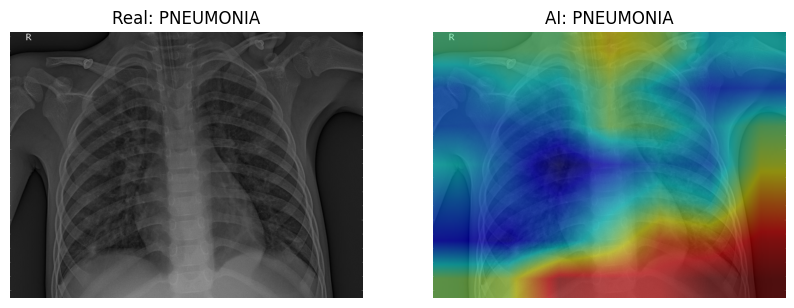

In [33]:
import matplotlib.pyplot as plt
# (numpy as np is already imported)

# 1. Compute Heatmap
target_layer = model.layer4[-1]
heatmap = GradCAM(model, target_layer)(img_tensor)

# 2. Show Image
original = np.array(img_pil) / 255.0
result = show_cam_on_image(original, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(original); plt.title(f"Real: {'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'}"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(result); plt.title(f"AI: {class_names[output.argmax().item()]}"); plt.axis('off')
plt.show()

In [34]:
print(f"Class Mapping: {train_data.class_to_idx}")
print(f"Class Names list: {class_names}")

Class Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Class Names list: ['NORMAL', 'PNEUMONIA']
